<a href="https://colab.research.google.com/github/xanasa14/MLImplementations/blob/master/TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt

toxic_comments = pd.read_csv("/content/drive/MyDrive/toxicCommentz/train.csv",engine='python',encoding='utf-8')
print(toxic_comments['severe_toxic'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0    0
1    0
2    0
3    0
4    0
Name: severe_toxic, dtype: int64


In [3]:
# Get the Data statistics
print("Number of rows:",toxic_comments.shape[0])
print("Number of columns:",toxic_comments.shape[1])
print("Column Names:",toxic_comments.columns.values.tolist())

Number of rows: 159571
Number of columns: 8
Column Names: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [4]:
# Check if data has any null values
print("Columns with Null Values:",toxic_comments.isnull().any())

Columns with Null Values: id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool


In [5]:
# Check if data has any missing values
print("Columns with Missing Values:",toxic_comments.columns[toxic_comments.isnull().any()].tolist())

Columns with Missing Values: []


In [6]:
import numpy as np
import pandas as pd
from sklearn import preprocessing,metrics,manifold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
from imblearn.over_sampling import ADASYN,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import collections
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import RobustScaler
import xgboost
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
from collections import Counter
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.metrics import classification_report,confusion_matrix
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [7]:
severetoxic_comments=toxic_comments[toxic_comments['severe_toxic']==1]['comment_text']
# Get Obscene Comments
obscene_comments=toxic_comments[toxic_comments['obscene']==1]['comment_text']
# Get Threat Comments
threat_comments=toxic_comments[toxic_comments['threat']==1]['comment_text']
# Get Insult Comments
insult_comments=toxic_comments[toxic_comments['insult']==1]['comment_text']
# Get Identity Hate Comments
identityhate_comments=toxic_comments[toxic_comments['identity_hate']==1]['comment_text']

In [8]:
print("TOXIC COMMENTS:\n".format(),toxic_comments[:5])
print("\nSEVERE TOXIC COMMENTS:\n".format(),severetoxic_comments[:5])
print("\nOBSCENE COMMENTS:\n".format(),obscene_comments[:5])
print("\nTHREAT COMMENTS:\n".format(),threat_comments[:5])
print("\nINSULT COMMENTS:\n".format(),insult_comments[:5])
print("\nIDENTITY HATE COMMENTS:\n".format(),identityhate_comments[:5])

TOXIC COMMENTS:
                  id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]

SEVERE TOXIC COMMENTS:
 6           COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
55     Stupid peace of shit stop deleting my stuff as...
181    you are a stupid fuck \n\nand your mother's cu...
442         Hi \n\nIm a fucking bitch.\n\n50.180.208.181
579    What a motherfucking piece of crap those fuckh...
Name: comment_text, dtype: object

OBSCENE COMMENTS:
 6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
42    You are gay or antisemmitian? \n\nArchangel WH...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
51    GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...
55    Stupid peace of shit stop deleting my stuff as...
Name: comment_text, dtype: object

THREAT COMMENTS:
 79      Hi! I am back again!\n

In [9]:
# Toxicity category columns
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Assigned to count all clean comments
value_counts_0 = []
# Assigned to count all offensive comments
value_counts_1 = []

for col in label_columns:
  value_counts_0.append(toxic_comments[col].value_counts()[0])
  value_counts_1.append(toxic_comments[col].value_counts()[1])

print("Number of clean comments:",value_counts_0)
print("Number of offensive comments:",value_counts_1)

Number of clean comments: [144277, 157976, 151122, 159093, 151694, 158166]
Number of offensive comments: [15294, 1595, 8449, 478, 7877, 1405]


findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Monsterrat'] not found. Falling back to DejaVu Sans.


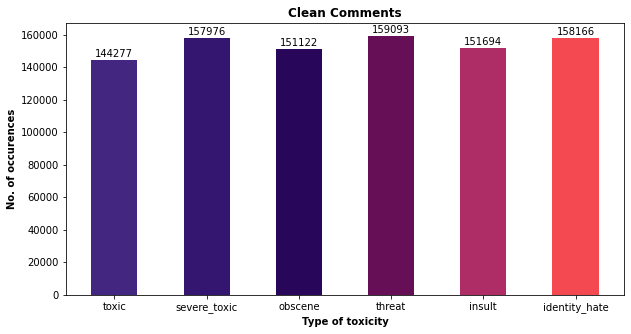

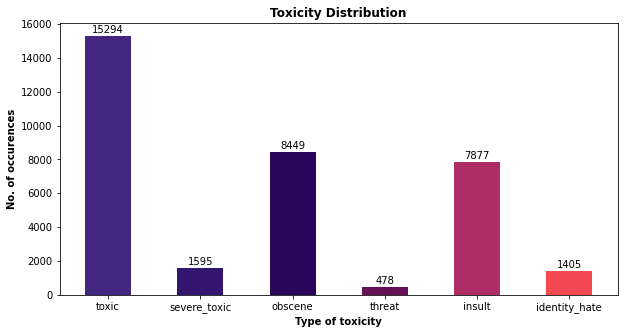

In [10]:
def plot_toxicity(labels,count,ylabel,xlabel,subtitle):
    fig = plt.figure(figsize = (10, 5)) 

    # creating the bar plot 
    plt.bar(labels,count, color=['#422680','#341671','#280659','#660F56','#AE2D67','#F54952'],  width = 0.5) 

    plt.xlabel(xlabel,fontweight ='bold',fontname='Monsterrat') 
    plt.ylabel(ylabel,fontweight ='bold',fontname='Monsterrat') 
    plt.title(subtitle,fontweight ='bold',fontname='Comic Sans MS') 

    for x,y in zip(labels,count):

        label = "{:}".format(y)

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,3), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or c
    
    plt.show() 

plot_toxicity(label_columns,value_counts_0,"No. of occurences","Type of toxicity","Clean Comments")
plot_toxicity(label_columns,value_counts_1,"No. of occurences","Type of toxicity","Toxicity Distribution")


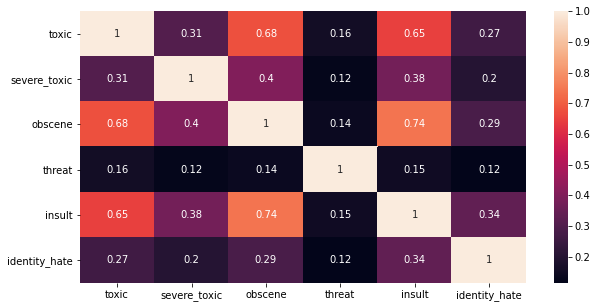

In [11]:
#Heat map to show the correlation
temp_df=toxic_comments.iloc[:,2:]
corr=temp_df.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [12]:
# Example of comments that are toxic and obscene
toxicnobscene_comments=toxic_comments[(toxic_comments['toxic']==1) & toxic_comments['obscene']==1]['comment_text']
print("TOXIC AND OBSCENE COMMENTS:\n".format(),toxicnobscene_comments[:5])

TOXIC AND OBSCENE COMMENTS:
 6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
42    You are gay or antisemmitian? \n\nArchangel WH...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
51    GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...
55    Stupid peace of shit stop deleting my stuff as...
Name: comment_text, dtype: object


In [13]:
# Example of comments that are toxic and severe_toxic
toxicnsevere_comments=toxic_comments[(toxic_comments['toxic']==1) & toxic_comments['severe_toxic']==1]['comment_text']
print("TOXIC AND SEVERE TOXIC COMMENTS:\n".format(),toxicnsevere_comments[:5])

TOXIC AND SEVERE TOXIC COMMENTS:
 6           COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
55     Stupid peace of shit stop deleting my stuff as...
181    you are a stupid fuck \n\nand your mother's cu...
442         Hi \n\nIm a fucking bitch.\n\n50.180.208.181
579    What a motherfucking piece of crap those fuckh...
Name: comment_text, dtype: object


In [14]:
# Example of comments that fall under all catgeories
allcat_comments=toxic_comments[(toxic_comments['toxic']==1) 
                    & (toxic_comments['severe_toxic']==1)
                    & (toxic_comments['obscene']==1)
                    & (toxic_comments['threat']==1)
                    & (toxic_comments['insult']==1)
                    & (toxic_comments['identity_hate']==1)]['comment_text']
print("Comments in all categories:\n".format(),allcat_comments[:5])
print("\nCount of comments in all categories:",allcat_comments.count())

Comments in all categories:
 1017     WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...
1312     SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!
7299     You're a stupid cunt \n\nFuck you dumb arse, y...
13648    Bitch \n\nYou are a little bitch. I fuckin spe...
13964    I am going to murder ZimZalaBim ST47 for being...
Name: comment_text, dtype: object

Count of comments in all categories: 31


In [15]:

# Summing up all the counts for toxic columns
x=toxic_comments.iloc[:,2:].sum()
# Calculate sum of rows
rowsums=toxic_comments.iloc[:,2:].sum(axis=1)
# marking comments without any tags as "clean"
# creates a new column with bool value marking as clean or offensive
toxic_comments['clean']=(rowsums==0)
#count number of clean entries
toxic_comments['clean'].sum()

print("Total comments:",len(toxic_comments))
print("Total clean comments:",toxic_comments['clean'].sum())
print("Total offensive comments:",x.sum())

Total comments: 159571
Total clean comments: 143346
Total offensive comments: 35098


In [16]:
# Count of all clean comments
count_clean=toxic_comments[toxic_comments['clean']==True]
# Count of all offensive comments
count_offensive=toxic_comments[toxic_comments['clean']==False]

Clean Words:0          43
1          17
2          42
3         113
4          13
         ... 
159566     47
159567     18
159568     12
159569     25
159570     36
Name: comment_text, Length: 143346, dtype: int64
Offensive Words:6           8
12         53
16         10
42        117
43          8
         ... 
159494    319
159514      6
159541     58
159546    103
159554     35
Name: comment_text, Length: 16225, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



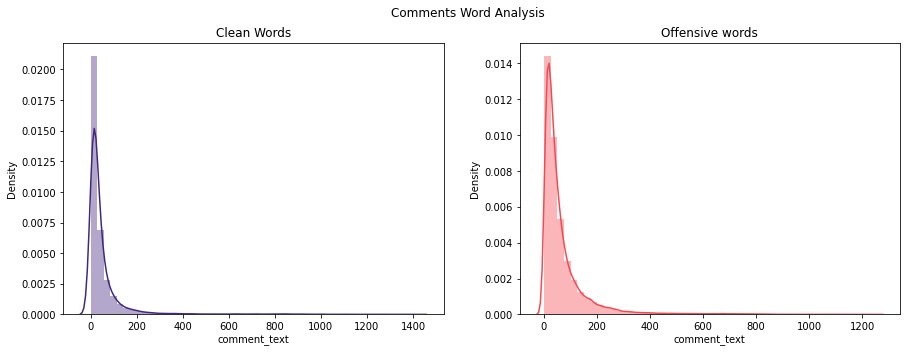

In [17]:
#Analyse the count of words in each segment
#Function for checking word length
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='#422680')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='#F54952')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


count_clean_words=count_clean['comment_text'].str.split().apply(lambda z:cal_len(z))
count_offensive_words=count_offensive['comment_text'].str.split().apply(lambda z:cal_len(z))
print("Clean Words:" + str(count_clean_words))
print("Offensive Words:" + str(count_offensive_words))
plot_count(count_clean_words,count_offensive_words,"Clean Words","Offensive words","Comments Word Analysis")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



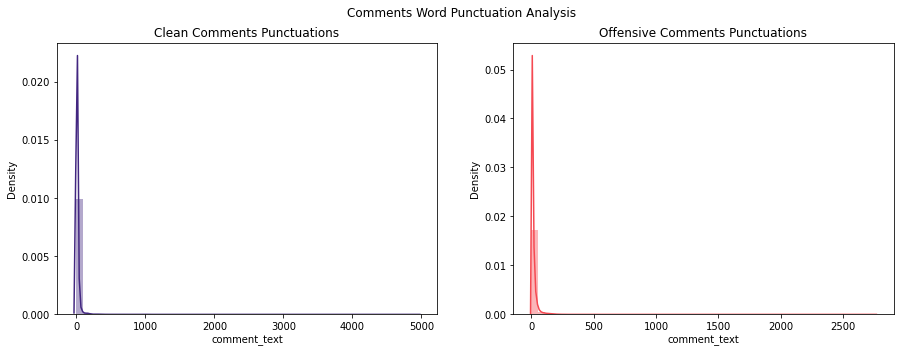

In [18]:
#Count Punctuations/Stopwords/Codes and other semantic datatypes
#We will be using the "generic_plotter" function.

count_clean_punctuations=count_clean['comment_text'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
count_offensive_punctuations=count_offensive['comment_text'].apply(lambda z:len([c for c in str(z) if c in string.punctuation]))
plot_count(count_clean_punctuations,count_offensive_punctuations,"Clean Comments Punctuations","Offensive Comments Punctuations","Comments Word Punctuation Analysis")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



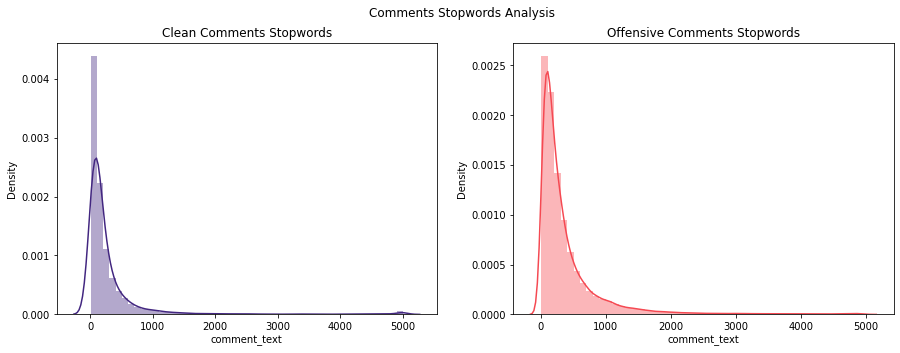

In [19]:
#Analyse Stopwords

def plot_count_1(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='#422680')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='#F54952')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


stops=set(stopwords.words('english'))
count_clean_stops=count_clean['comment_text'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
count_offensive_stops=count_offensive['comment_text'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
plot_count_1(count_clean_stops,count_offensive_stops,"Clean Comments Stopwords","Offensive Comments Stopwords","Comments Stopwords Analysis")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



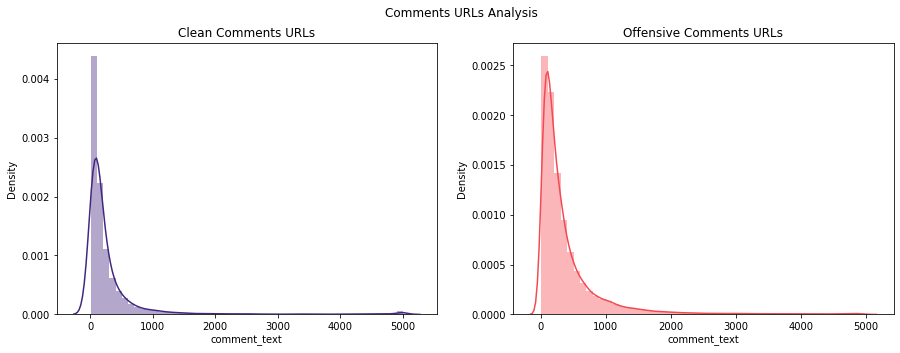

In [20]:
## Checking number of Urls
count_clean_urls=count_clean['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
count_offensive_urls=count_offensive['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

plot_count_1(count_clean_stops,count_offensive_stops,"Clean Comments URLs","Offensive Comments URLs","Comments URLs Analysis")

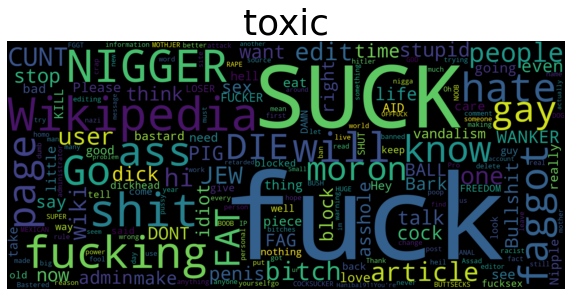

In [22]:
#WordCloud Visualizations
#Method for creating wordclouds
from PIL import Image
def display_cloud(data,label):
    plt.subplots(figsize=(10,10))
    text = data[data[label]==1]["comment_text"].tolist()
    wc = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=1800,
                          height=800,
                         )
    wc.generate(' '.join(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(label,fontsize=36)
    plt.show()
    
display_cloud(toxic_comments,"toxic")

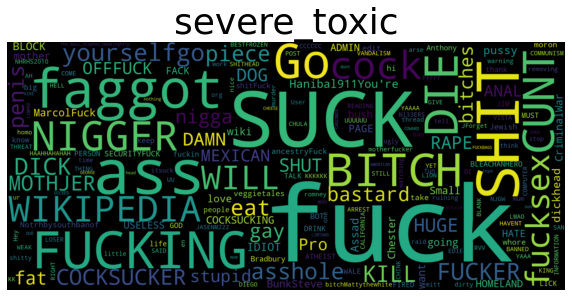

In [24]:
display_cloud(toxic_comments,"severe_toxic")


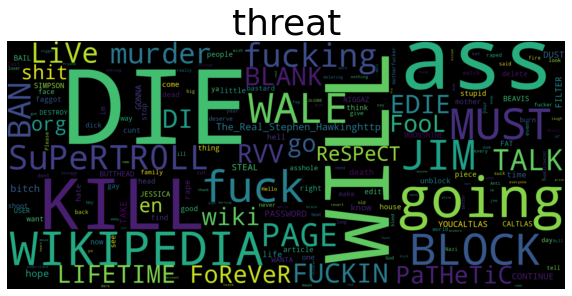

In [26]:
display_cloud(toxic_comments,"threat")


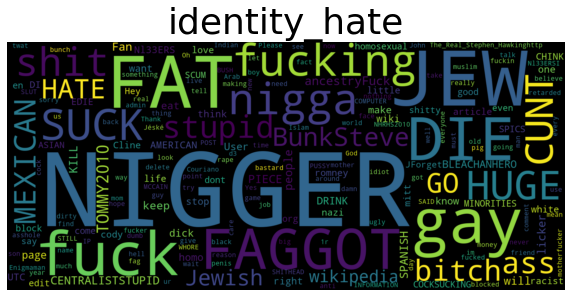

In [27]:
display_cloud(toxic_comments,"identity_hate")


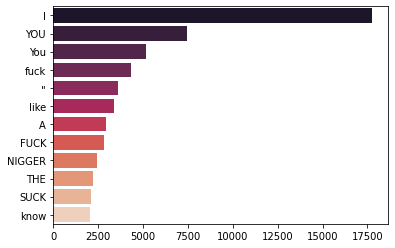

In [29]:
#Simplified counter function
def create_corpus(word):
    corpus=[]
    
    for x in toxic_comments[toxic_comments['clean']==word]['comment_text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def plotword(corpus):
    counter=Counter(corpus)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:50]:
        if (word not in stops) :
            x.append(word)
            y.append(count)
    return sns.barplot(x=y,y=x,palette="rocket")
# Top words for offensive comments
corpus=create_corpus(False)
plotword(corpus)

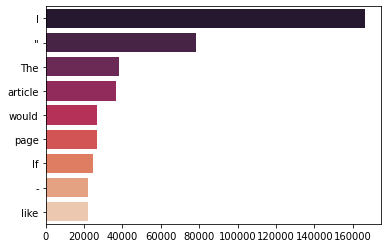

In [30]:
# Top words for clean comments
corpus=create_corpus(True)
plotword(corpus)

In [40]:
#Data Cleaning¶
%%time
import re
def remove_punctuations(data):
    punct_tag=re.compile(r'[\.,!?;:]+')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

toxic_comments['comment_text']=toxic_comments['comment_text'].apply(lambda z: remove_punctuations(z))
toxic_comments['comment_text']=toxic_comments['comment_text'].apply(lambda z: remove_html(z))
toxic_comments['comment_text']=toxic_comments['comment_text'].apply(lambda z: remove_url(z))
toxic_comments['comment_text']=toxic_comments['comment_text'].apply(lambda z: remove_emoji(z))

CPU times: user 5.49 s, sys: 622 µs, total: 5.49 s
Wall time: 5.5 s


In [42]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data)  
    return data


toxic_comments['comment_text']=toxic_comments['comment_text'].apply(lambda z: remove_abb(z))

In [45]:
# Count of clean and offensive comments
count_good=toxic_comments[toxic_comments['clean']==True]
count_bad=toxic_comments[toxic_comments['clean']==False]

In [46]:
#Apply Gram Analysis
train_df_zero=count_bad['comment_text']
train_df_ones=count_good['comment_text']

print(train_df_zero)

6              COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12        Hey what is it\n@ | talk \nWhat is it an exclu...
16        Bye \n\ndo not look come or think of comming b...
42        You are gay or antisemmitian \n\nArchangel WHi...
43                   FUCK YOUR FILTHY MOTHER IN THE ASS DRY
                                ...                        
159494    "\n\n our previous conversation \n\nyou fuckin...
159514                    YOU ARE A MISCHIEVIOUS PUBIC HAIR
159541    Your absurd edits \n\nYour absurd edits on gre...
159546    "\n\nHey listen do not you ever Delete my edit...
159554    and I am going to keep posting the stuff u del...
Name: comment_text, Length: 16225, dtype: object


In [51]:

%%time
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

def lemma_traincorpus(text):
    lemm_words = " ".join([lemm.lemmatize(word) for word in text.split()])    
    return lemm_words
                        


toxic_comments['comment_text']=toxic_comments['comment_text'].apply(lambda z: lemma_traincorpus(z))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
CPU times: user 40.4 s, sys: 259 ms, total: 40.7 s
Wall time: 41 s


In [53]:
%%time
tfidf_vect=TfidfVectorizer(stop_words='english',ngram_range=(1,3))
train_tfidf=tfidf_vect.fit_transform(toxic_comments['comment_text'].values.tolist())
train_tfidf.shape

CPU times: user 1min 5s, sys: 2.47 s, total: 1min 8s
Wall time: 1min 8s


In [54]:
## Outputs from the TF-IDF transformed data
print(train_tfidf)

  (0, 4114243)	0.15342817590096927
  (0, 5651757)	0.14477289689071532
  (0, 5705187)	0.11298703091162478
  (0, 4813935)	0.1419865194082257
  (0, 2117884)	0.15342817590096927
  (0, 1789531)	0.15342817590096927
  (0, 6606516)	0.15342817590096927
  (0, 3863669)	0.15342817590096927
  (0, 6223396)	0.15342817590096927
  (0, 2375002)	0.15342817590096927
  (0, 1161386)	0.15342817590096927
  (0, 3093381)	0.15342817590096927
  (0, 6151977)	0.15342817590096927
  (0, 4916683)	0.15342817590096927
  (0, 2164610)	0.15342817590096927
  (0, 3665680)	0.15342817590096927
  (0, 2598941)	0.1483651622466918
  (0, 6114103)	0.1483651622466918
  (0, 1907363)	0.15342817590096927
  (0, 2097242)	0.15342817590096927
  (0, 4902252)	0.15342817590096927
  (0, 4114240)	0.1419865194082257
  (0, 5649516)	0.045889007022180114
  (0, 5705182)	0.1072102842530975
  (0, 4813916)	0.11699418254079819
  :	:
  (159570, 937164)	0.1560742808628455
  (159570, 642815)	0.16354096377168972
  (159570, 657096)	0.17367262116241491
  (1595

In [56]:
#Converting the data to Binary numbers¶


In [64]:
%%time
train_li=[]
for i in range(len(toxic_comments)):
    if (toxic_comments['clean'][i]==False):
        train_li.append(1)
    else:
        train_li.append(0)
toxic_comments['Binary']=train_li
print(toxic_comments['Binary'].head())

0    0
1    0
2    0
3    0
4    0
Name: Binary, dtype: int64
CPU times: user 1.21 s, sys: 937 µs, total: 1.21 s
Wall time: 1.22 s
